# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

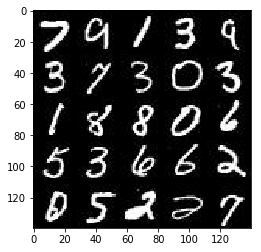

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

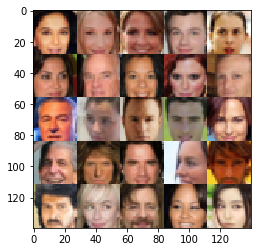

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [40]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [41]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 4 * 4 * 512
    alpha = 0.2
    stddev = 0.05
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(
            images, 
            128, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.random_normal_initializer(stddev=stddev)
        )
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(
            x1, 
            256, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.random_normal_initializer(stddev=stddev)
        )
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(
            x2, 
            512, 
            5, 
            strides=2, 
            padding='same',
            kernel_initializer=tf.random_normal_initializer(stddev=stddev)
        )
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, n_units))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    num_units = 7*7*512
    output_w_h = 28
    stddev = 0.05
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, num_units)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)    
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    total_steps = epoch_count * batch_size
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


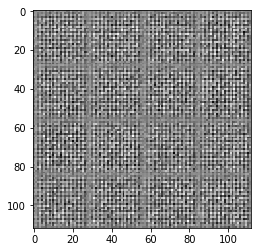

Epoch 1/2... Discriminator Loss: 2.8795... Generator Loss: 0.0962
Epoch 1/2... Discriminator Loss: 2.7204... Generator Loss: 0.1110
Epoch 1/2... Discriminator Loss: 1.7864... Generator Loss: 1.7155
Epoch 1/2... Discriminator Loss: 2.5015... Generator Loss: 0.1390
Epoch 1/2... Discriminator Loss: 1.6553... Generator Loss: 1.5283
Epoch 1/2... Discriminator Loss: 1.9140... Generator Loss: 1.9280
Epoch 1/2... Discriminator Loss: 1.6540... Generator Loss: 1.5390
Epoch 1/2... Discriminator Loss: 1.6871... Generator Loss: 1.5939
Epoch 1/2... Discriminator Loss: 1.8574... Generator Loss: 0.2609
Epoch 1/2... Discriminator Loss: 1.6606... Generator Loss: 0.3494


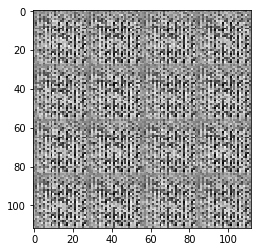

Epoch 1/2... Discriminator Loss: 1.6382... Generator Loss: 0.3626
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.3889
Epoch 1/2... Discriminator Loss: 1.5368... Generator Loss: 0.4375
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.5128
Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 0.4455
Epoch 1/2... Discriminator Loss: 1.4792... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 1.4900... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 0.5033


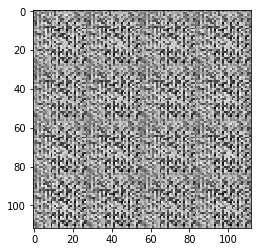

Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.4376
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 1.0496
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 1.1248
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 1.1118
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 1.1694
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 1.1403
Epoch 1/2... Discriminator Loss: 3.4487... Generator Loss: 3.8042


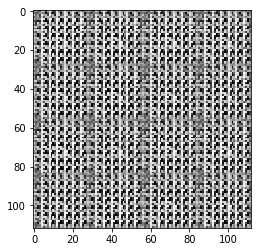

Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 1.2135
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 1.0572
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 1.1025
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 1.0172
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 1.0674


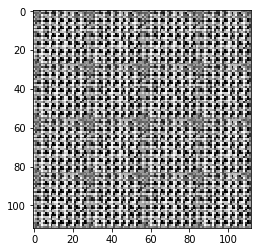

Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 1.0159
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 1.0433
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 1.0334
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.9988
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 1.0019


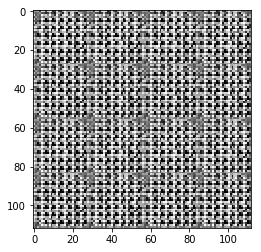

Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 1.0051
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 1.0000
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 1.0098
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 1.0232


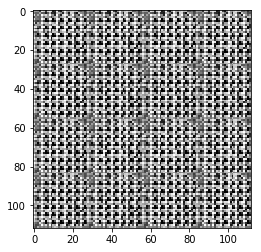

Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 1.0265
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 1.0799
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 1.0384
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.9470


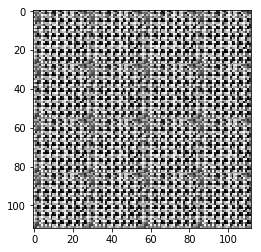

Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 1.1690
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.5932... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 1.1489
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 1.0044
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 1.0050


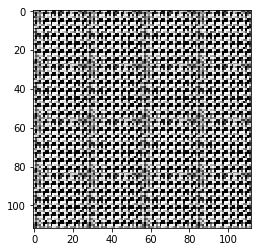

Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.9541
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.9433
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.9732
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.9653


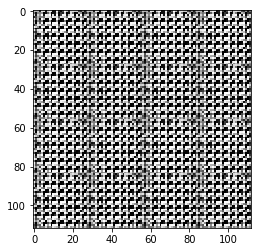

Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.9658
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.9658
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.9587


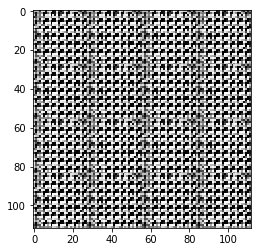

Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.9510
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.9555
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.9717
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.9865
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.9726


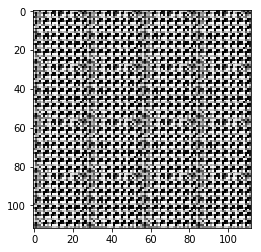

Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.9659
Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.9855
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.9667
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 1.0023


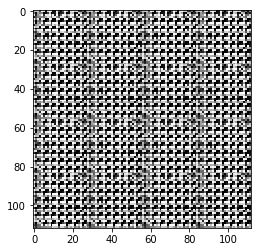

Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.9906
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.9568
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.9627
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.9626


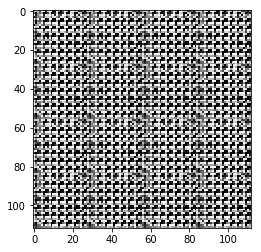

Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.9571
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.9978
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.9830


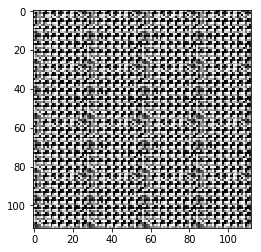

Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.9917
Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.9767
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.9662


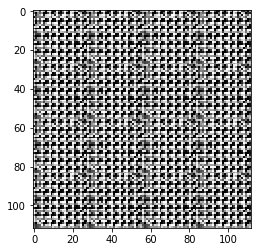

Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.9798
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.9778
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.9836
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.4035... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 1.4032... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.9815


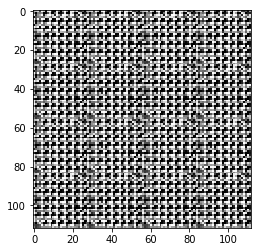

Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.9909
Epoch 2/2... Discriminator Loss: 1.4045... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 1.0132


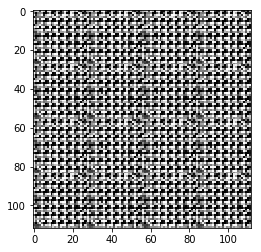

Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 1.0094
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.9944
Epoch 2/2... Discriminator Loss: 1.3989... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.9797


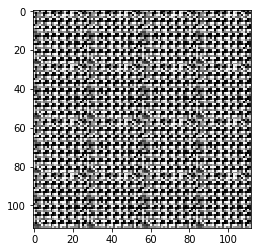

Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.9656
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.9734
Epoch 2/2... Discriminator Loss: 1.4032... Generator Loss: 0.9946


In [48]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        mnist_dataset.get_batches,
        mnist_dataset.shape, 
        mnist_dataset.image_mode
    )
    #plt.plot(losses)
    #plt.show()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.